# PDPD-SL: Pickup and delivery with drone and scheduled lines

Current assumptions:
- drone capacity = 1; bus capacity unlimited
- all drones are deployed; all parcels are served
- bus runs like a conveyor belt
- no drone battery constraints
- all parcel orders are ready to be picked up without time window constraints
- each parcel travels the path with the least total drone flight distance

In [1]:
from optimization_functions import *

# optimization parameters set in preprocess_functions.py

import pandas as pd

from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

import pickle
import csv

## Variables

#### Drones $\mathcal{M}$, $|\mathcal{M}| = m$
- unlimited battery life
- each drone serves a subtour that starts and ends at the same depot, with origin $o^{orig} \in \mathcal{O}_m^{orig}$, and destination $o^{dest} \in \mathcal{O}_m^{dest}$ arcs connecting nodes in $\mathcal{N} \times \mathcal{N}$

"Since the fleet of vehicles is homogeneous and uses the same depot, and each node can only be visited once, it is not necessary to explicitly know which vehicle visits each node. As long as information is available about which arcs that are used, it is possible to build up all the vehicle itineraries anyway. This makes it possible to reduce the number of binary variables substantially." IDARP (Häll et al 2008)


#### Nodes $\mathcal{N} = \mathcal{O} \cup \mathcal{N^p} \cup \mathcal{N^d} \cup \mathcal{T}$
- set of replicated depots per drone (assume unlimited battery) $\mathcal{O}$, each depot replicated $2m$ times, representing origin and destination depots for each drone
- set of pick up nodes $\mathcal{N^p}$
- set of delivery nodes $\mathcal{N^d}$, $|\mathcal{N^p}| = |\mathcal{N^d}| = n$
- set of replicated bus stops $\mathcal{T}$, $|\mathcal{T}|= |\mathcal{S}| \cdot n$
    - contains each physical stop $s \in \mathcal{S}$ is replicated $n$ times. $T^s_i$ is the replicated stop of physical stop $s$ related to parcel $i$. 
    - assume bus high frequency and high capacity like conveyor belt]
- set of arcs $\mathcal{A}$. $A_{ij}=1$ if an arc can exist between two nodes. ie. 0 means that an arc cannot go from depot to drop off, or drop off to pick up of the same task



Some intuition:
- Each drone enters and exits a node maximum once; if enter=1, then exit=1.
- If a parcel traverses an arc, the arc should also be traversed by a bus or a drone.

#### Parcel paths $\mathcal{P}$
- $n$ paths: one path for each ($\mathcal{N}^p_i, \mathcal{N}^d_i$) pair
- each path $\mathcal{P}_i$ starts at the parcel's origin $\mathcal{N}^p_i$, and ends at the parcel's destination $\mathcal{N}^d_i$; possible path configurations:
    - (i) drone direct flight: arc ($\mathcal{N}^p_i, \mathcal{N}^d_i$)
    - (ii) drone ($\mathcal{N}^p_i, \mathcal{T}^s_i$), bus ($\mathcal{T}^s_i$, ......)


- all paths are connected by drone flights ($\mathcal{O}, \mathcal{N}^p_i$)

Bus unlimited capacity, so drone can bring parcel at any time.

#### Parcel paths $\mathcal{P}$
- $n$ paths: one path for each ($\mathcal{N}^p_i, \mathcal{N}^d_i$) pair
- each path $\mathcal{P}_i$ starts at the parcel's origin $\mathcal{N}^p_i$, and ends at the parcel's destination $\mathcal{N}^d_i$; possible path configurations:
    - (i) drone direct flight: arc ($\mathcal{N}^p_i, \mathcal{N}^d_i$)
    - (ii) drone ($\mathcal{N}^p_i, \mathcal{T}^s_i$), bus ($\mathcal{T}^s_i$, ......)


- all paths are connected by drone flights ($\mathcal{O}, \mathcal{N}^p_i$)

Bus unlimited capacity, so drone can bring parcel at any time.

#### Physical bus stops $\mathcal{S}$, bus lines $\mathcal{L}= \{L_1\}$ one line for now

Set of physical bus stops nearest (denoted by *) to each pick up node $p$: $\mathcal{S^{p*}}$, where $|\mathcal{S^{p*}}| = n$;

Set of physical bus stops nearest to each delivery node: $\mathcal{S^{d*}}$, where $|\mathcal{S^{d*}}| = n$;

To create arcs in $\mathcal{N} \times \mathcal{N}$

- Set of replicated bus stops nearest to each pick up node: $\mathcal{T^{p*}}$, where $|\mathcal{T^{p*}}| = n$, ex. $\mathcal{T^{p*}} = \{T_{i=0}^{s_0}, T_{i=1}^{s_0}, T_{i=2}^{s_1}, T_{i=3}^{s_3} \}$

- Set of replicated bus stops nearest to each pick up node: $\mathcal{T^{d*}}$, where $|\mathcal{T^{d*}}| = n$, ex. $\mathcal{T^{d*}} = \{T_{i=0}^{s_2}, T_{i=1}^{s_3}, T_{i=2}^{s_3}, T_{i=3}^{s_2} \}$

#### Optimal solution description 

First decide on a path on each parcel, then optimize

- Drone subtours indicating node [depot, parcel, bus stop] visit sequence (based on what type of nodes a drone arc connects, one can infer drone status, occupancy, previous/next node)

- Times when each node is visited; although the paths already contain sequence, we also need a timetable, since 
    - although the travel times can be determined afterwards, it is usually necessary to compute wait times at bus stops



## Data and model

#### Step 1: data

##### Tasks

In [2]:
# Parcel pickup (N^p) and delivery (N^d)
# [Parcel ID | time (minutes) | pickup_x (km) | pickup_y | delivery_x | delivery_y | immediate: False=0, True=1]

# Option 1: toy network for testing
# task_array = np.array([[0, 1, 1, 3.7, 3, 2.5,  0], 
#                        [1, 3, 1, 1, 5, 3.7, 0], 
#                        [2, 10, 2, 1, 5.2, 3.5, 0],
#                        [3, 14, 4.2, 1, 3.2, 0.5, 0],
#                        [4, 20, 5, 3, 5.5, 3.5, 0]])

# task_array = np.array([[0, 1, 1, 3.7, 3, 2.5,  0], 
#                        [1, 3, 1, 1, 5, 3.7, 0]])

# Option 2: a larger network
num_tasks = 49
with open('DATA_PDPD-SL/' + str(num_tasks) + 'tasks', 'rb') as f:
    task_array = pickle.load(f)

# take a subset of tasks to test
task_array = task_array[:10]


In [3]:
task_df = pd.DataFrame(columns=['ID', 'time', 'pickup_x', 'pickup_y', 'delivery_x', 'delivery_y', 'immediate'],
                       data=task_array)
num_tasks = len(task_df)

##### Bus stops

In [4]:
# Bus stops, line(s), timetable
# [Stop ID | line | stop_x (km) | stop_y (km)]

# Option 1: toy network for testing
# stop_array = np.array([[0, 0, 1, 2.6],
#                        [1, 0, 2, 2.6],
#                        [2, 0, 3, 2.6],
#                        [3, 0, 4, 2.6]])

# # Bus travel times between adjacent stops = 2 minutes per 1 km. Below calculates automatically
# bus_travel_times = {(0, 1): 2,
#                     (1, 2): 2,
#                     (2, 3): 2,
#                     (3, 2): 2,
#                     (2, 1): 2,
#                     (1, 0): 2
#                     }

# # Option 2: a larger network
with open('DATA_PDPD-SL/1busline', 'rb') as f:
    stop_array = pickle.load(f)

# take a subset of bus stops to test
# stop_array = stop_array[:2]

stop_df = pd.DataFrame(columns=['ID', 'line', 'stop_x', 'stop_y'],
                       data=stop_array)

num_stops = len(stop_df)

In [5]:
stop_df

,ID,line,stop_x,stop_y
0,0.0,0.0,3.0,2.0
1,1.0,0.0,3.0,3.0
2,2.0,0.0,3.0,4.0
3,3.0,0.0,3.0,5.0
4,4.0,0.0,3.0,6.0
5,5.0,0.0,3.0,7.0
6,6.0,0.0,3.0,7.0
7,7.0,0.0,4.0,7.0
8,8.0,0.0,5.0,7.0
9,9.0,0.0,6.0,7.0


In [6]:
bus_travel_times = calc_bus_travel_times(num_stops, stop_df, v_bus)

In [7]:
bus_trips = []
num_bus_trips = 10 # create one bus trip at a time, alternating terminus departures
terminus_depart_time = 0
headway = 3 # minutes, taken as the duration of a complete trip in one direction

for trip in range(num_bus_trips):
    trip_dict = {'ID': trip}
    direction = 0 if trip%2==0 else 1
    
    if direction==0:
        start_time = terminus_depart_time
        # iterate through stops from left to right
        for start_stop in range(num_stops-1):
            trip_dict[(start_stop, start_stop+1)] = start_time
            # start_time at the next stop
            start_time += bus_travel_times[(start_stop, start_stop+1)]

    else: # direction==1
        start_time = terminus_depart_time
        # iterate through stops from right to left
        for start_stop in range(num_stops-1, 0, -1):
            trip_dict[(start_stop, start_stop-1)] = start_time

            # start_time at the next stop
            start_time += bus_travel_times[(start_stop, start_stop-1)]
        terminus_depart_time += headway
    
    bus_trips.append(trip_dict)

##### Depot

In [8]:
# Drone depots
# [Depot ID | depot_x (km) | depot_y (km)]
# depot_array = np.array([[0, 1.1, 3.6]])
depot_array = np.array([[0, 2, 2]])

depot_df = pd.DataFrame(columns=['ID', 'depot_x', 'depot_y'],
                         data=depot_array)
num_depots = len(depot_df)

##### Drone


In [9]:
# Drone fleet size
num_drones = 2

#### Step 2: Create feasible arcs

In [10]:
(nodes_list, num_depots_repl, depots_orig_list, depots_orig_list_concat, depots_dest_list, depots_dest_list_concat, 
            pickup_list, delivery_list, bus_stop_list) = create_all_nodes(num_depots, num_drones, num_tasks, num_stops)
num_nodes = len(nodes_list)

In [11]:
bus_stop_list

[[22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
 [32, 33, 34, 35, 36, 37, 38, 39, 40, 41],
 [42, 43, 44, 45, 46, 47, 48, 49, 50, 51],
 [52, 53, 54, 55, 56, 57, 58, 59, 60, 61],
 [62, 63, 64, 65, 66, 67, 68, 69, 70, 71],
 [72, 73, 74, 75, 76, 77, 78, 79, 80, 81],
 [82, 83, 84, 85, 86, 87, 88, 89, 90, 91],
 [92, 93, 94, 95, 96, 97, 98, 99, 100, 101],
 [102, 103, 104, 105, 106, 107, 108, 109, 110, 111],
 [112, 113, 114, 115, 116, 117, 118, 119, 120, 121],
 [122, 123, 124, 125, 126, 127, 128, 129, 130, 131]]

In [12]:
arcs = create_all_arcs(num_depots_repl, bus_stop_list, pickup_list, delivery_list, 
                    depots_dest_list_concat, num_tasks, bus_travel_times)

##### Compute drone arc distances for all node pairs

In [13]:
nodes_coords_dict = get_node_coords(depot_df, task_df, stop_df, num_drones, bus_stop_list)
dist_drone_arcs, dist_drone_dict = calc_drone_arc_dist(num_nodes, big_M, nodes_coords_dict)


##### Compute bus travel times for all node pairs

In [14]:
time_bus_arcs = calc_time_bus_arcs(num_nodes, big_M, bus_travel_times, num_tasks, bus_stop_list)

#### Step 3: Parcel arcs: direct, all nearest bus stop, or flexible

In [18]:
parcel_arcs = create_parcel_arcs(scenario, pickup_list, delivery_list, bus_stop_list, dist_drone_arcs, num_tasks)

##### Plot all nodes and visualize parcel arcs

([], [])

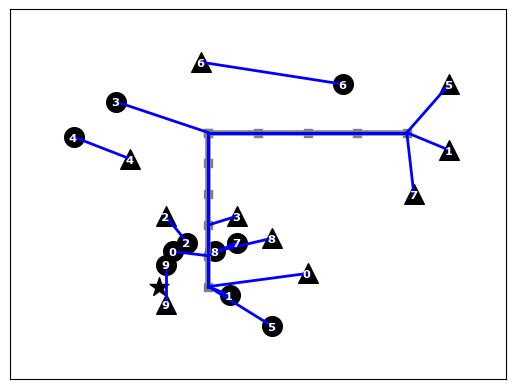

In [16]:
plot_all_nodes(stop_df, task_df, depot_df, nodes_coords_dict)
for arc in parcel_arcs:
    plt.plot([nodes_coords_dict[arc[0]][0], nodes_coords_dict[arc[1]][0]],
             [nodes_coords_dict[arc[0]][1], nodes_coords_dict[arc[1]][1]],
             c='b', linewidth=2
             )
    
plt.xticks([])
plt.yticks([])

# plt.savefig('FIGURES/illustration_parcel_arcs.pdf')

#### Step 4: Gurobi variables and constraints (reference PDPTW-SL paper and PDP paper by Dumas)

In [19]:
# Gurobi model
model = gp.Model("PDPD-SL")
(model, x_drone_arc, makespan, beta_drone, 
 alpha_drone, beta_parcel, alpha_parcel, x_parcel_arc) = set_up_grb_model(model, obj, cost_drone_per_km, cost_drone_per_minute,
                                                        parcel_arcs, arcs, num_nodes, big_M, num_drones, 
                                                        nodes_list, pickup_list, delivery_list, 
                                                        depots_orig_list, depots_orig_list_concat,
                                                        depots_dest_list, depots_dest_list_concat,
                                                        dist_drone_arcs, v_drone, dist_drone_dict, 
                                                        bus_travel_times, bus_stop_list, t_bus_dwell, time_bus_arcs
                                                        )

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-14


In [18]:
model.params.Threads = 6
model.setParam('PoolSolutions', 4)  # Keep multiple solutions if found, good idea since the depot replication induces symmetry
model.setParam(GRB.Param.PoolSearchMode, 2)
model.setParam("MIPFocus", 1)  # Prioritizes finding feasible solutions
model.setParam("Heuristics", 0.5)  # Increases heuristic effort
model.setParam("MIPGap", 0.1) # Report optimal solution if optimality gap is less than 10%

# model.setParam('TimeLimit', 1200)  # Limit to 20 minutes

model.optimize()

Set parameter Threads to value 6
Set parameter PoolSolutions to value 4
Set parameter PoolSearchMode to value 2
Set parameter MIPFocus to value 1
Set parameter Heuristics to value 0.5
Set parameter MIPGap to value 0.1
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 6 threads

Optimize a model with 1576 rows, 3833 columns and 11359 nonzeros
Model fingerprint: 0xa2eb153f
Model has 2980 general constraints
Variable types: 537 continuous, 3296 integer (3296 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [2e-01, 9e+00]
  Bounds range     [1e+00, 6e+01]
  RHS range        [1e+00, 9e+00]
  GenCon rhs range [2e-01, 9e+00]
  GenCon coe range [1e+00, 1e+00]
Presolve added 1265 rows and 0 columns
Presolve removed 0 rows and 1940 columns
Presolve time: 0.04s
Presolved: 2841 rows, 1893 columns, 9973 nonzeros
Variable types: 105 continuous, 1788 integer (1788 bin

In [19]:
if model.Status == GRB.INFEASIBLE:
    model.computeIIS()
    model.write("iis.ilp")
else:
    print('Model feasible')

Model feasible


In [20]:
# for var in model.getVars():
#     if var.IISLB:
#         print(f"Infeasible lower bound: {var.VarName}")
#     if var.IISUB:
#         print(f"Infeasible upper bound: {var.VarName}")

In [21]:
# for constr in model.getConstrs():
#     if constr.IISConstr:
#         print(f"Infeasible constraint: {constr.ConstrName}")

In [22]:
num_solutions = model.SolCount
print(f"Number of stored solutions: {num_solutions}")

Number of stored solutions: 4


In [23]:
# Print objective values of solutions
for e in range(num_solutions):
    model.setParam(GRB.Param.SolutionNumber, e)
    print(f"{model.PoolObjVal:g} ", end="")
    if e % 15 == 14:
        print("")
print("")


51.4022 51.4022 51.4022 51.4022 


##### Store optimization results

In [24]:
# First term: Drone travel cost
term1_value = x_drone_arc.prod(dist_drone_dict).getValue()

# Second term: Makespan cost
term2_value = makespan.X

# Print results
print(f"Drone travel distance (km): {term1_value}")
print(f"Makespan time (minutes): {term2_value}")

Drone travel distance (km): 51.4021772043255
Makespan time (minutes): 65.0


## Solution retrieval

Print drone path and visit time one by one, example:

- Drone ID: depot i (time) - Np_i (time) - T_i (time) - ... - ... - depot (time)

    - Np_i (time) - T_i (time) - T_i (time) - Nd_i (time)
    - Np_i (time) - Nd_i (time)

- Drone ID: depot i (time) - Np_i (time) - T_i (time) - ... - ... - depot (time)

    - Np_i (time) - T_i (time) - T_i (time) - Nd_i (time)
    - Np_i (time) - Nd_i (time)

Given drone ID: plot trajectory of drone on map, with pick up and delivery points, and bus stops labeled.

TODO: Given task ID: plot trajectory of parcel on map, with Np, Nd, and bus stops in background. 


#### Sanity check

Print out arcs to draw out paths for each drone

Drone 0: Depot 0 (0.0) -> Pickup 9 (0.589) -> Delivery 9 (1.875) -> Pickup 4 (5.377) -> Delivery 4 (6.725) -> Bus stop 5 (9.443) -> Delivery 3 (11.552) -> Pickup 6 (13.695) -> Delivery 6 (16.64) -> Pickup 5 (18.783) -> Bus stop 10 (20.573) -> Pickup 7 (26.304) -> Bus stop 10 (28.309) -> Pickup 1 (29.34) -> Bus stop 10 (30.37) -> Pickup 8 (34.743) -> Delivery 8 (35.963) -> Bus stop 1 (44.309) -> Delivery 7 (45.024) -> Bus stop 1 (46.294) -> Delivery 0 (47.022) -> Bus stop 0 (48.37) -> Delivery 1 (63.543) -> Depot 0 (65.0)
Drone 1: Depot 0 (0.0) -> Pickup 3 (2.804) -> Bus stop 2 (3.443) -> Pickup 2 (22.733) -> Delivery 2 (23.692) -> Bus stop 0 (38.573) -> Delivery 5 (40.391) -> Pickup 0 (42.248) -> Bus stop 0 (44.294) -> Depot 0 (45.294)


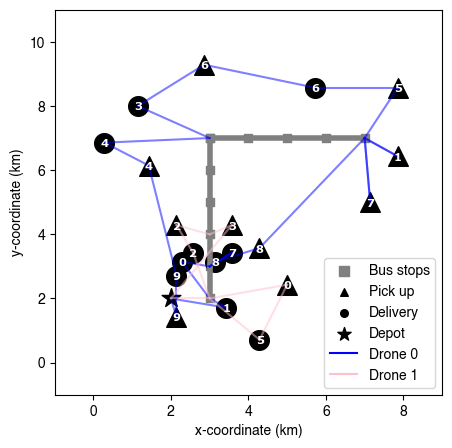

In [25]:
plt.figure(figsize=(5, 5))
plot_all_nodes(stop_df, task_df, depot_df, nodes_coords_dict)
        
# for (i, j) in x_drone_arc.keys():
#     if x_drone_arc[i, j].X>=0.5:
#         plt.plot([nodes_coords_dict[i][0], nodes_coords_dict[j][0]],
#                  [nodes_coords_dict[i][1], nodes_coords_dict[j][1]], 
#                  c='b', alpha=0.5)
        
drone_arcs_solution = store_drone_arcs_soln(depots_orig_list, num_drones, x_drone_arc, 
                          depots_orig_list_concat, depots_dest_list_concat,
                          pickup_list, delivery_list, bus_stop_list, beta_drone, alpha_drone)

plot_drone_arcs_soln(drone_arcs_solution, num_drones, nodes_coords_dict, dist_drone_arcs)

# plt.savefig('FIGURES/PDPDSL_soln.pdf')

#### Parcel status visusalization

In [26]:
# Store each parcel path as a dictionary since the number of entries isn't always the same

all_parcels = []
for task_ID in range(num_tasks):
    parcel_dict = {}
    parcel_dict['task_ID'] = task_ID
    
    # Time the parcel is picked up by drone from the origin
    parcel_dict['beta_P'] = round(beta_parcel[pickup_list[task_ID]].Xn, 3)
    pickup_node = pickup_list[task_ID]

    # Time the parcel is dropped off by drone at the destination
    parcel_dict['alpha_D'] = round(alpha_parcel[delivery_list[task_ID]].Xn, 3)
    delivery_node = delivery_list[task_ID]

    # Departure times from bus stops, if applicable, list of times
    parcel_dict['bus_stop_departures'] = []
    key_i_list = [key[0] for key in x_parcel_arc.keys()]
    key_j_list = [key[1] for key in x_parcel_arc.keys()]

    next_i = key_j_list[np.where(np.array(key_i_list)==pickup_node)[0][0]]
    while next_i != delivery_node:
        parcel_dict['bus_stop_departures'].append(round(beta_parcel[next_i].Xn, 3))
        next_i = key_j_list[np.where(np.array(key_i_list)==next_i)[0][0]]

    all_parcels.append(parcel_dict)

([<matplotlib.axis.YTick at 0x121b4fed0>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4'),
  Text(0, 5, '5'),
  Text(0, 6, '6'),
  Text(0, 7, '7'),
  Text(0, 8, '8'),
  Text(0, 9, '9')])

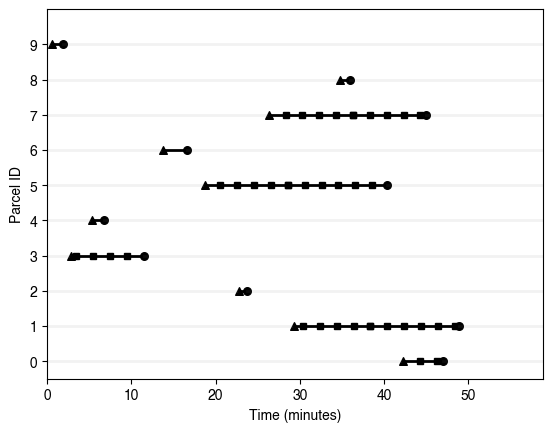

In [27]:
plt.plot(figsize=(1.5, 1.5))
plt.xlabel('Time (minutes)')
plt.ylabel('Parcel ID')
end_time = max([parcel['alpha_D'] for parcel in all_parcels]) + 10

linewidth = 2


for i, parcel in enumerate(all_parcels):
    # grey before parcel is picked up
    plt.plot([0, parcel['beta_P']], [i, i], marker=None, c='grey', linewidth=linewidth, alpha=0.1)
    if parcel['bus_stop_departures']==[]:
        # direct drone flight
        plt.plot([parcel['beta_P'], parcel['alpha_D']], [i, i], marker=None, c='k', linewidth=linewidth, markersize=5)
    else:
        
        plt.plot([parcel['beta_P'], parcel['bus_stop_departures'][0]], [i, i], 
                 marker=None, c='k', linewidth=linewidth, markersize=5)        

        plt.plot([parcel['bus_stop_departures'][-1], parcel['alpha_D']], [i, i], 
                 marker=None, c='k', linewidth=linewidth, markersize=5)


        plt.plot(parcel['bus_stop_departures'], [i] * len(parcel['bus_stop_departures']), 
                 marker='s', c='k', linewidth=linewidth, markersize=5)

    # Green after parcel is delivered
    plt.plot([parcel['alpha_D'], end_time], [i, i], marker=None, c='grey', linewidth=linewidth, alpha=0.1)
    
    # plot pick up and delivery nodes
    plt.scatter(parcel['beta_P'], i, marker='^', c='k', s=30)
    plt.scatter(parcel['alpha_D'], i, marker='o', c='k', s=30)


# legend
# triange: pick up node; square: bus stop; circle: delivery node
# plt.legend()

plt.xlim(0, end_time)
plt.ylim(-0.5, num_tasks)
# plt.xticks(np.arange(0, end_time, 2))
plt.yticks(np.arange(0, num_tasks, 1))

# plt.savefig('FIGURES/parcel_times.pdf')